# Sample Mass-Difference Networks in Metabolomics Data Analysis

Notebook to support the study on the application of **Sample M**ass-**Di**fference **N**etworks as a highly specific competing form of pre-processing procedure for high-resolution metabolomics data.

Mass-Difference Networks are focused into making networks from a list of masses. Each _m/z_ will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences used to build said networks are called a set of MDBs - Mass-Difference-based Building block.

This is notebook `paper_sMDiNs_supervised.ipynb`


## Organization of the Notebook

- Loading up pre-processed and pre-treated datasets databases with intensity-based pre-treated data and data from sMDiNs analyses.
- **Random Forest - optimization, predictive accuracy and important features: comparison after aplication of different pre-treatment procedures.**
- **PLS-DA - optimization, predictive accuracy and important features: comparison after aplication of different pre-treatment procedures.**


#### Needed Imports

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

import seaborn as sns
import networkx as nx

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

In [3]:
# json for persistence

import json
from time import perf_counter

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `MDiN`: Mass-Difference Network - Not present here, only on sMDiNsAnalysis notebook
- `<treatment name>`: transformed data matrix / network. These treatment names can be
    - `original`: an alias to `data`
    - `Ionly`: missing value imputed data by 1/5 of the minimum value in each sample in the dataset, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `Ionly_RF`: missing value imputed data by random forests, only
    - `P_RF`: Pareto scaled data
    - `NP_RF`: Pareto scaled and normalized
    - `NGP_RF`: normalized, glog transformed and Pareto scaled
    - **`IDT`: `NGP_RF` or `NGP` - Intensity-based Data pre-Treatment chosen as comparison** based on which of the two performed better for each dataset and each statistical method
    - `sMDiN`: Sample Mass-Difference Networks - Not present here, only on sMDiNsAnalysis notebook
       
- `<sMDiN analysis name>`: data matrix from nework analysis of MDiNs
    - **`Degree`: degree analysis of each sMDiN**
    - **`Betweenness`: betweenness centrality analysis of each sMDiN**
    - **`Closeness`: closeness centrality of analysis of each sMDiN**
    - **`MDBI`: analysis on the impact of each MDB (Mass-Difference based building-block) on building each sMDiN**
    - **`GCD11`: Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets) between each sMDiN.**

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD)
- vitis_types (GD types)
- HD (HD)

#### Data Pre-Treatment

For information on the **commonly used intensity based data pre-treatments** and about the **benchmark datasets**, see notebook `paper_sMDiNs_database_prep.ipynb`.

For information on the **building** and the different **network analysis methods** used for the **Sample MDiNs** and information about the Mass-Difference-based Building blocks (**MDBs**), see notebook `paper_sMDiNs_sMDiNsAnalysis.ipynb`.

### Reading datasets database

In [4]:
# Read benchmark datasets
path = Path.cwd() / "store_files" / 'processed_data.json'
storepath = Path.cwd() / "store_files" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
#datasets

In [5]:
# Selecting a placeholder for the Intensity-based Data pre-Treatment (IDT)
# Chosen for each dataset and each method based on which between NGP and NGP_RF generated the best results
for name, ds in datasets.items():
    ds['IDT'] = ds['NGP_RF']  

In [6]:
#fname = 'store_files/datasets.json'
#with open(fname, "r", encoding='utf8') as read_file:
#    datasets = json.load(read_file)

In [7]:
#for dskey, ds in datasets.items():
#    if dskey.startswith('YD'):
#        ds['data'] = pd.DataFrame(ds['data']['data'], index=ds['data']['index'], columns=ds['data']['columns'])
#        ds['original'] = ds['data']
    
#    else:
#        df_idx = pd.MultiIndex.from_tuples(ds['data']['index'])
#        df_data = pd.DataFrame(ds['data']['data'], index=df_idx, columns=ds['data']['columns'])
#        df_data.index.set_names('label', level=0, inplace=True)
        
#        ds['data'] = df_data
#        ds['original'] = df_data
        
    # Checkpoint to see if the data is equal
    #assert_frame_equal(datasets[dskey]['data'], datasets2[dskey]['data'])

Extra Possibly Useful Data

In [8]:
# Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances-https://ciaaw.org/isotopic-abundances.htm/https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
# Isotopic abundances from Pure Appl. Chem. 2016; 88(3): 293–306,
# Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503

chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078) # Carbon 13 isotope
           } 

# electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
electron_mass = 0.000548579909065

In [9]:
# Chemical Formula transformations (MDBs chosen)
MDBs = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']

### Colors for plots to ensure consistency

#### 11 variety grapevine data sets

In [10]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

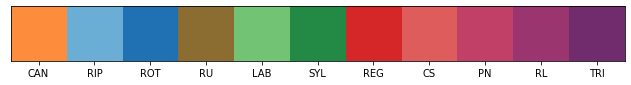

In [11]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [12]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_classes = datasets['YD']['classes']
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]

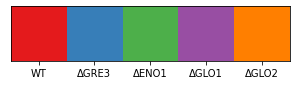

In [13]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types (wild and _vinifera_)

In [14]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

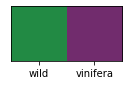

In [15]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

#### 2 HD classes

In [16]:
# customize label colors for 2 HD classes

colours = sns.color_palette('Set1', 2)
hd_label_colors = {lbl: c for lbl, c in zip(datasets['HD']['classes'], colours)}
datasets['HD']['label_colors'] = hd_label_colors
datasets['HD']['sample_colors'] = [hd_label_colors[lbl] for lbl in datasets['HD']['target']]

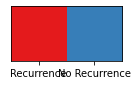

In [17]:
sns.palplot(hd_label_colors.values())
new_ticks = plt.xticks(range(len(datasets['HD']['classes'])), datasets['HD']['classes'])

Samples and respective target labels of each dataset

In [18]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [19]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [20]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [21]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [22]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

#### Colors for the pre-treatments / sMDiN analysis metrics for the plots

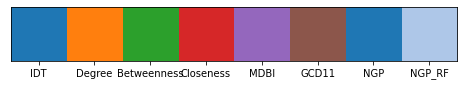

In [23]:
# customize colors for the intensity-based pre-treatment and analysis metrics of sample MDiNs
treatments = ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11', 'NGP', 'NGP_RF')

treat_colors = tab10cols[:6]
#treat_colors.extend(tab10cols[6:8])
treat_colors.extend(tab20cols[:2])
treatment_colors = {lbl: c for lbl, c in zip(treatments, treat_colors)}

sns.palplot(treatment_colors.values())
new_ticks = plt.xticks(range(len(treatment_colors)), treatment_colors)

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5-fold cross-validation in `vitis_types` and in `HD`).

Each method will be applied to the differently-treated datasets for each of the benchmark datasets.

**Note**: If `Generate` is **True**, Random Forest and PLS-DA will be applied. They are always on the cell before the application.

## Random Forests

### Optimization of the number of trees

Random Forest models with different number of trees are built to assess when the predictive accuracy of the different models stops increasing with the number of trees. Grid search of number of trees from 10 to 200 for the random forests with 5 tree interval. See where the cross-validation estimated predictive accuracy stops improving for each one.

In [24]:
GENERATE = True

In [25]:
np.random.seed(16)
if GENERATE:

    top_tree_in_grid=200

    # Vector with values for the parameter n_estimators
    # Models will be built from 10 to top_tree_in_grid trees in 5 tree intervals
    values = {'n_estimators': range(10,top_tree_in_grid,5)}

    rf = skensemble.RandomForestClassifier(n_estimators=200)
    clf = GridSearchCV(rf, values, cv=3)
    clf_2class = GridSearchCV(rf, values, cv=5)

    # For each dataset, building the Random Forest models with the different number of trees
    # and storing the predictive accuracy (estimated by k-fold cross-validation)
    param = []
    test_score = []
    for name, dataset in datasets.items():
        for treatment in ('NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            print('Fitting', name, treatment, '...', end=' ')
            if name in ('vitis_types', 'HD'):
                clf2use = clf_2class
            else:
                clf2use = clf
            clf2use.fit(dataset[treatment], dataset['target'])
            param.append(clf2use.cv_results_['param_n_estimators'])
            test_score.append(clf2use.cv_results_['mean_test_score'])
            print('Done!')

    RF_optim = {'param': param, 'test_score': test_score}
    #fname = 'store_files/RF_optim.json'
    #with open(fname, "w", encoding='utf8') as write_file:
        #json.dump(RF_optim, write_file)

Fitting GD_neg_global2 NGP ... Done!
Fitting GD_neg_global2 NGP_RF ... Done!
Fitting GD_neg_global2 Degree ... Done!
Fitting GD_neg_global2 Betweenness ... Done!
Fitting GD_neg_global2 Closeness ... Done!
Fitting GD_neg_global2 MDBI ... Done!
Fitting GD_neg_global2 GCD11 ... Done!
Fitting GD_pos_global2 NGP ... Done!
Fitting GD_pos_global2 NGP_RF ... Done!
Fitting GD_pos_global2 Degree ... Done!
Fitting GD_pos_global2 Betweenness ... Done!
Fitting GD_pos_global2 Closeness ... Done!
Fitting GD_pos_global2 MDBI ... Done!
Fitting GD_pos_global2 GCD11 ... Done!
Fitting GD_neg_class2 NGP ... Done!
Fitting GD_neg_class2 NGP_RF ... Done!
Fitting GD_neg_class2 Degree ... Done!
Fitting GD_neg_class2 Betweenness ... Done!
Fitting GD_neg_class2 Closeness ... Done!
Fitting GD_neg_class2 MDBI ... Done!
Fitting GD_neg_class2 GCD11 ... Done!
Fitting GD_pos_class2 NGP ... Done!
Fitting GD_pos_class2 NGP_RF ... Done!
Fitting GD_pos_class2 Degree ... Done!
Fitting GD_pos_class2 Betweenness ... Done!
Fit

In [26]:
#fname = 'store_files/RF_optim.json'
#with open(fname, "r", encoding='utf8') as read_file:
    #RF_optim = json.load(read_file)

#param = RF_optim['param']
#test_score = RF_optim['test_score']

#### Plots of tree number optimization

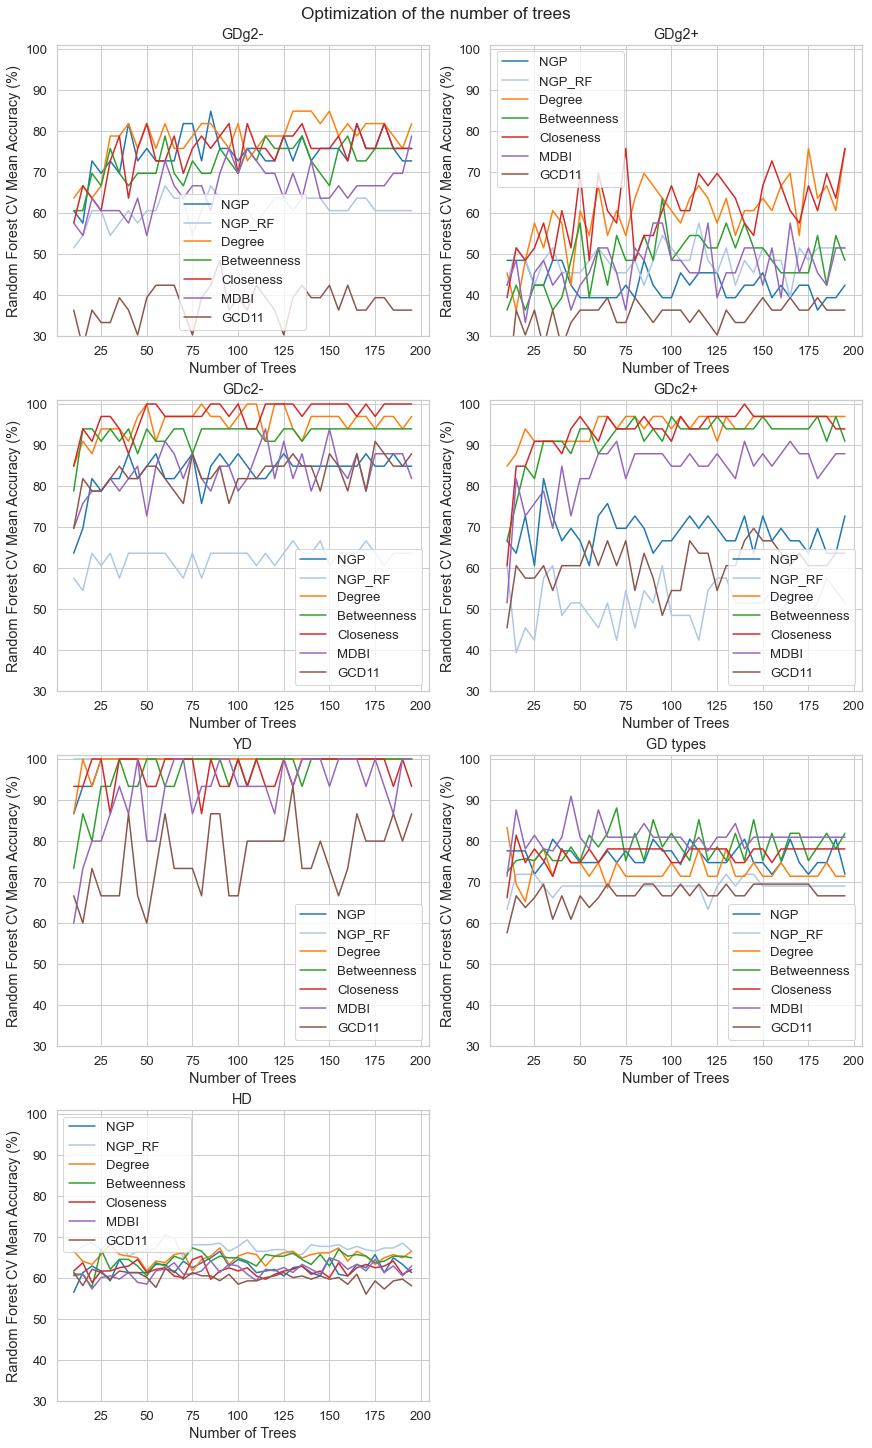

In [27]:
# Plotting the results and adjusting parameters of the plot

def plot_RF_otimization_ntrees(irange, param, test_score, ax=None, ylabel='', title='', ylim=(30,101)):
    col = treat_colors[-2:] + treat_colors[1:]
    if ax is None:
        ax = plt.gca()
    for i in irange:
        ax.plot(param[i], test_score[i]*100, color = col[i%7])
    ax.set(ylabel=ylabel, xlabel='Number of Trees', ylim=ylim, title=title)
    ax.legend(('NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'))

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(4, 2, figsize=(12,20), constrained_layout=True)
        ranges = [range(i, i+7) for i in (0, 7, 14, 21, 28, 35, 42)]
        titles = ['GDg2-', 'GDg2+', 'GDc2-', 'GDc2+', 'YD', 'GD types', 'HD']
        
        for irange, title, ax in zip(ranges, titles, axs.ravel()):
        
            plot_RF_otimization_ntrees(irange, param, test_score, ax=ax,
                                       ylabel='Random Forest CV Mean Accuracy (%)',
                                       title=title)
        
        axs[3][1].remove()
        
        f.suptitle('Optimization of the number of trees')

        plt.show()

### Random Forest models

Random Forest models were built with the `RandomForestClassifier` from scikit-learn using the `RF_model_CV` from multianalysis.py (each step explained better there).

This function performs n iterations to randomly sample the folds in k-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) datasets. 

It then stores predictive accuracy of the models (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn of each iteration.

In [28]:
GENERATE = True # False

In [29]:
np.random.seed(16)
if GENERATE:

    iter_num=20
    #iter_num=100

    RF_all = {}
    
    # Application of the Random Forests for each differently-treated dataset
    for name, dataset in datasets.items():
        
        # Intensity-based pre-treatments
        IDT_res = {}
        for treatment in ('NGP', 'NGP_RF'):
            print(f'Fitting random forest for {name} with treatment {treatment}', end=' ...')
            IDT_res[treatment] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_fold = 5 if name in ('vitis_types', 'HD') else 3

            fit = ma.RF_model_CV(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            IDT_res[treatment].update(fit)

            print(f'done')
        
        # Choose the Intensity-based Data pre-Treatment (IDT) with the highest accuracy
        if np.mean(IDT_res['NGP_RF']['accuracy']) >= np.mean(IDT_res['NGP']['accuracy']):
            rfname = name + ' ' + 'IDT'
            RF_all[rfname] = IDT_res['NGP_RF']
            RF_all[rfname]['treatment'] = 'IDT'
        else:
            rfname = name + ' ' + 'IDT'
            RF_all[rfname] = IDT_res['NGP']
            RF_all[rfname]['treatment'] = 'IDT'
        
        # Data matrices from the network analyses of sMDiNs
        for treatment in ('Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            print(f'Fitting random forest for {name} with treatment {treatment}', end=' ...')
            rfname = name + ' ' + treatment
            RF_all[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_fold = 5 if name in ('vitis_types', 'HD') else 3

            fit = ma.RF_model_CV(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            RF_all[rfname].update(fit)

            print(f'done')
    
    # Store Results
    fname = 'store_files/RF_all.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(RF_all, write_file)

Fitting random forest for GD_neg_global2 with treatment NGP ...done
Fitting random forest for GD_neg_global2 with treatment NGP_RF ...done
Fitting random forest for GD_neg_global2 with treatment Degree ...done
Fitting random forest for GD_neg_global2 with treatment Betweenness ...done
Fitting random forest for GD_neg_global2 with treatment Closeness ...done
Fitting random forest for GD_neg_global2 with treatment MDBI ...done
Fitting random forest for GD_neg_global2 with treatment GCD11 ...done
Fitting random forest for GD_pos_global2 with treatment NGP ...done
Fitting random forest for GD_pos_global2 with treatment NGP_RF ...done
Fitting random forest for GD_pos_global2 with treatment Degree ...done
Fitting random forest for GD_pos_global2 with treatment Betweenness ...done
Fitting random forest for GD_pos_global2 with treatment Closeness ...done
Fitting random forest for GD_pos_global2 with treatment MDBI ...done
Fitting random forest for GD_pos_global2 with treatment GCD11 ...done
Fi

In [30]:
# Read prior results
fname = 'store_files/RF_all.json'
with open(fname, "r", encoding='utf8') as read_file:
    RF_all = json.load(read_file)

#### Results of the Random Forest - Performance (Predictive Accuracy) 

In [31]:
# Accuracy across the iterations
accuracies = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracies

,GD_neg_global2 IDT,GD_neg_global2 Degree,GD_neg_global2 Betweenness,GD_neg_global2 Closeness,GD_neg_global2 MDBI,GD_neg_global2 GCD11,GD_pos_global2 IDT,GD_pos_global2 Degree,GD_pos_global2 Betweenness,GD_pos_global2 Closeness,...,vitis_types Betweenness,vitis_types Closeness,vitis_types MDBI,vitis_types GCD11,HD IDT,HD Degree,HD Betweenness,HD Closeness,HD MDBI,HD GCD11
0,0.787879,0.787879,0.757576,0.878788,0.636364,0.424242,0.424242,0.515152,0.515152,0.575758,...,0.938095,0.971429,0.966667,0.876190,0.903673,0.839347,0.843429,0.771184,0.703265,0.686939
1,0.696970,0.818182,0.727273,0.818182,0.575758,0.393939,0.484848,0.606061,0.606061,0.575758,...,0.938095,0.971429,0.938095,0.790476,0.883347,0.867673,0.831429,0.775184,0.710776,0.650531
2,0.727273,0.787879,0.757576,0.727273,0.666667,0.393939,0.424242,0.696970,0.575758,0.515152,...,0.942857,1.000000,0.966667,0.819048,0.887510,0.887673,0.823429,0.779265,0.690776,0.662612
3,0.757576,0.727273,0.696970,0.818182,0.606061,0.393939,0.545455,0.575758,0.606061,0.606061,...,0.938095,1.000000,0.904762,0.880952,0.891755,0.867429,0.823184,0.794857,0.747020,0.687347
4,0.696970,0.848485,0.757576,0.757576,0.575758,0.424242,0.484848,0.696970,0.363636,0.606061,...,0.933333,0.938095,0.971429,0.823810,0.887673,0.883510,0.831429,0.823347,0.702939,0.650531
5,0.818182,0.818182,0.696970,0.818182,0.606061,0.454545,0.545455,0.515152,0.424242,0.606061,...,0.933333,1.000000,0.938095,0.971429,0.875429,0.891755,0.827347,0.782939,0.727020,0.662776
6,0.757576,0.848485,0.727273,0.787879,0.515152,0.454545,0.484848,0.515152,0.545455,0.727273,...,0.938095,0.942857,0.971429,0.871429,0.903755,0.859673,0.803184,0.771184,0.706857,0.670612
7,0.727273,0.787879,0.727273,0.787879,0.606061,0.424242,0.484848,0.636364,0.545455,0.606061,...,0.942857,1.000000,0.885714,0.800000,0.867020,0.859184,0.827429,0.795102,0.727347,0.706857
8,0.787879,0.818182,0.696970,0.757576,0.575758,0.424242,0.606061,0.575758,0.666667,0.545455,...,0.938095,0.966667,0.966667,0.880952,0.887510,0.879429,0.819673,0.766939,0.711020,0.662857
9,0.757576,0.787879,0.818182,0.757576,0.636364,0.454545,0.424242,0.545455,0.484848,0.666667,...,0.938095,0.971429,0.971429,0.804762,0.879592,0.883592,0.815184,0.774939,0.702939,0.702694


#### Distributions of Predictive Accuracies for _GDg2-_

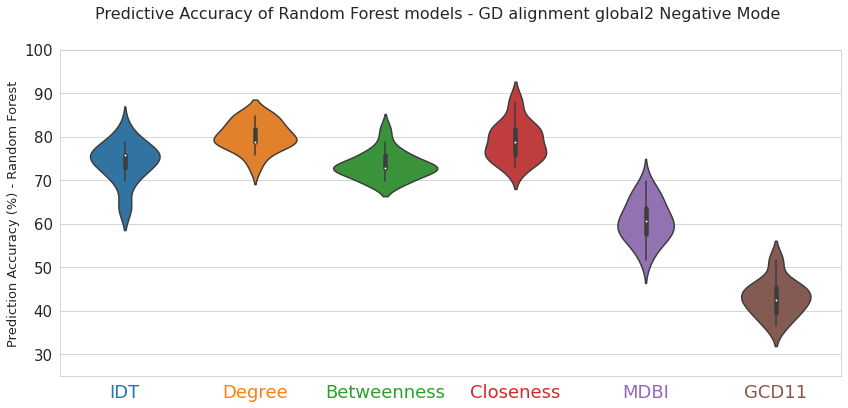

In [32]:
column_names = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']

# Violin plot of the distribution of the predictive accuracy (in %) across the iterations of randomly sampled folds for each 
# differently-treated dataset.

cols2keep = [col for col in accuracies.columns if 'neg_global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    colors = treat_colors
    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of Random Forest models - GD alignment global2 Negative Mode', fontsize=16)

In [33]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 IDT,0.740909,0.046609,GDg2-,IDT
GD_neg_global2 Degree,0.801515,0.033304,GDg2-,Degree
GD_neg_global2 Betweenness,0.734848,0.030895,GDg2-,Betweenness
GD_neg_global2 Closeness,0.789394,0.043387,GDg2-,Closeness
GD_neg_global2 MDBI,0.606061,0.047151,GDg2-,MDBI
GD_neg_global2 GCD11,0.430303,0.041246,GDg2-,GCD11
GD_pos_global2 IDT,0.492424,0.049035,GDg2+,IDT
GD_pos_global2 Degree,0.601515,0.060825,GDg2+,Degree
GD_pos_global2 Betweenness,0.530303,0.075837,GDg2+,Betweenness
GD_pos_global2 Closeness,0.601515,0.056713,GDg2+,Closeness


#### Average Predictive Accuracies of Random Forest models

Error bars were built based on the standard deviation of the predictive accuracies.

In [34]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})

accuracy_stats = accuracy_stats.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 IDT,0.740909,0.046609,GDg2-,IDT
GD_neg_global2 Degree,0.801515,0.033304,GDg2-,Degree
GD_neg_global2 Betweenness,0.734848,0.030895,GDg2-,Betweenness
GD_neg_global2 Closeness,0.789394,0.043387,GDg2-,Closeness
GD_neg_global2 MDBI,0.606061,0.047151,GDg2-,MDBI
GD_neg_global2 GCD11,0.430303,0.041246,GDg2-,GCD11
GD_pos_global2 IDT,0.492424,0.049035,GDg2+,IDT
GD_pos_global2 Degree,0.601515,0.060825,GDg2+,Degree
GD_pos_global2 Betweenness,0.530303,0.075837,GDg2+,Betweenness
GD_pos_global2 Closeness,0.601515,0.056713,GDg2+,Closeness


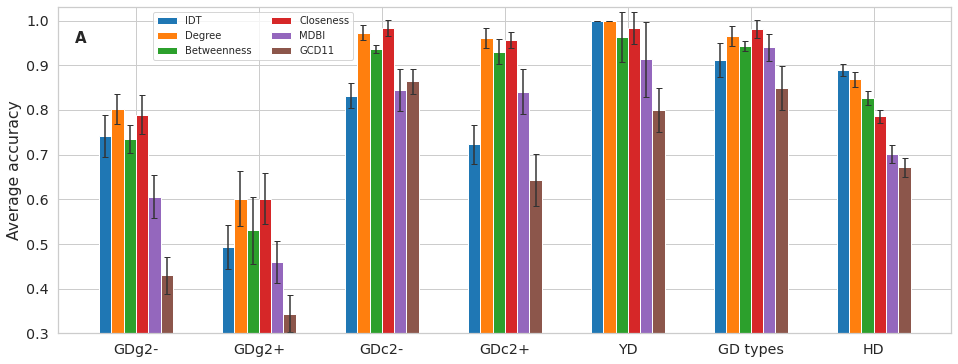

In [35]:
p4 = treat_colors
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(16, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.1  # the width of the bars
        for i, treatment in enumerate(('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.25 + i * 0.1
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.3,1.03))
        ax.text(-0.5, 0.95, 'A', weight='bold', fontsize=15)
        ax.legend(loc='upper left', bbox_to_anchor=(0.10, 1), ncol=2, fontsize=10)
        #f.savefig('images/RF_performance.pdf' , dpi=200)
        #f.savefig('images/RF_performance.png' , dpi=600)

#### ROC curves

ROC curves are computed for the `vitis_types` and `HD` classifiers only (2-class problems) using `RandomForestClassifier` from scikit-learn in the function `RF_ROC_cv` from multianalysis.py.

In [36]:
np.random.seed(16)
names = ['vitis_types','HD']
pos_labels = ['vinifera', 'Recurrence']
resROC = {}

# Perform and obtain the results for the ROC curves
for name,pos_label in zip(names, pos_labels):
    np.random.seed(16)
    dataset = datasets[name]
    #datasets[name]['IDT'] = datasets[name]['NGP']
    y = dataset['target']
    resROC[name] = {}
    for treatment in ('NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
        df = dataset[treatment]
        res = ma.RF_ROC_cv(df, y, pos_label, n_fold=5, n_trees=100, n_iter=20)
        # Selecting the best out of NGP and NGP_RF intensity-based data pre-treatments based on AUC and storing as 'IDT'
        if treatment == 'NGP':
            res_temp = res
        elif treatment == 'NGP_RF':
            if res['mean AUC'] >= res_temp['mean AUC']:
                resROC[name]['IDT'] = res
            else:
                resROC[name]['IDT'] = res_temp
        # Data matrices from the network analyses of sMDiNs
        else:
            resROC[name][treatment] = res

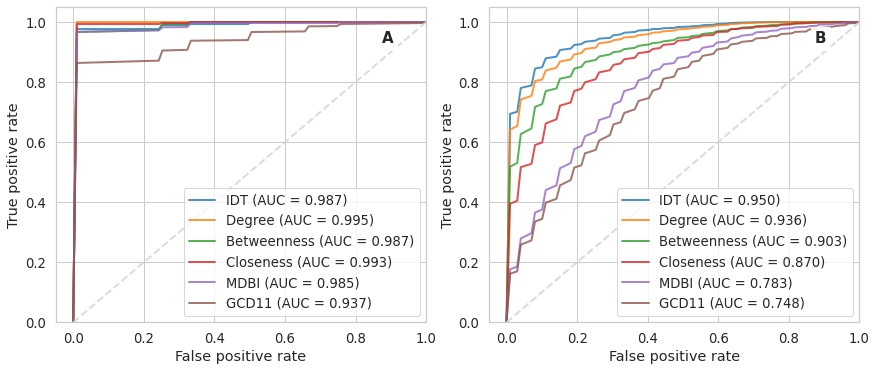

In [37]:
# Plot the ROC curves 
p4 = sns.color_palette('tab10', 6)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
        for rROC, ax in zip(resROC.values(), axs.ravel()):
            for treatment, color in zip(rROC, p4):
                res = rROC[treatment]
                mean_fpr = res['average fpr']
                mean_tpr = res['average tpr']
                mean_auc = res['mean AUC']
                ax.plot(mean_fpr, mean_tpr, color=color,
                       label=f'{treatment} (AUC = {mean_auc:.3f})',
                       lw=2, alpha=0.8)
            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
            ax.legend()
            ax.set_xlim(None,1)
            ax.set_ylim(0,None)
            ax.set(xlabel='False positive rate', ylabel='True positive rate')
            
        for letter, ax in zip('AB', axs.ravel()[0:2]):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.9))
        
        f.savefig('images/ROC_vitis.pdf', dpi=600)
        f.savefig('images/ROC_vitis.png', dpi=600)

### Important feature analysis - Random Forest

In [38]:
def build_impfeat_table(Imp_Feat_dict, original_df, colnames=['Feature', 'Importance Metric']):
    "Transform Imp. Feat. dict into a table (df) with the place, name of the feature and the score of the importance metric."
    Imp_Feats_Table = pd.DataFrame(columns=colnames)
    for n in range(len(Imp_Feat_dict)):
        MDBtype = original_df.columns[Imp_Feat_dict[n][0]]
        Imp_Feats_Table.loc[n+1] = MDBtype, Imp_Feat_dict[n][1]
    Imp_Feats_Table.index.name = 'Place'
    
    return Imp_Feats_Table

In [39]:
MDB_RF_Imp_Feat = {}
for dskey, ds in RF_all.items():
    if dskey.endswith('MDBI'):
        name, treat = dskey.split()
        MDB_RF_Imp_Feat[name] = build_impfeat_table(ds['important_features'], datasets[name][treat], 
                                                     colnames=['Feature', 'Gini Imp.'])

In [40]:
MDB_RF_Imp_Feat['vitis_types']

,Feature,Gini Imp.
Place,,
1,H2,0.180675
2,O,0.176755
3,CONH,0.156006
4,SO3,0.134643
5,NH3(O-),0.087916
6,H2O,0.057582
7,CO,0.036364
8,CO2,0.035137
9,C2H2O,0.035068


In [41]:
MDB_RF_Imp_Feat['YD']

,Feature,Gini Imp.
Place,,
1,PO3H,0.085121
2,S,0.082449
3,CO,0.082009
4,CH2,0.081315
5,H2,0.075346
6,CO2,0.075176
7,NH3(O-),0.074854
8,O,0.073448
9,CONH,0.072151


In [42]:
MDB_RF_Imp_Feat['HD']

,Feature,Gini Imp.
Place,,
1,CO,0.089920
2,PO3H,0.089856
3,CO2,0.083252
4,SO3,0.080111
5,CHOH,0.077863
6,O,0.071138
7,O(N-H-),0.066866
8,S,0.064656
9,CONH,0.059149


Building a Heatmap of the MDB Impact data matrix obtained for the YD benchmark dataset.

For visualization purposes, to compare the different MDBs that can have different magnitudes, auto-scaling was employed.

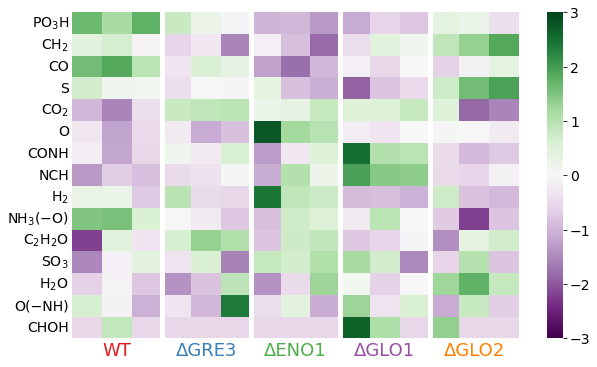

In [43]:
#sns.heatmap
f, ax = plt.subplots(figsize=(10,6))

tf = transf.FeatureScaler(method='standard')
df = tf.fit_transform(datasets['YD']['MDBI'].loc[:,list(MDB_RF_Imp_Feat['YD']['Feature'])])

MDB_2 = [f'PO$_3$H', 'CH$_2$', 'CO', 'S', 'CO$_2$', 'O', 'CONH', 'NCH', 'H$_2$', 'NH$_3$(−O)', 'C$_2$H$_2$O', 'SO$_3$',
         'H$_2$O', 'O(−NH)', 'CHOH']

#mapa = sns.diverging_palette(300, 200, s=60, as_cmap=True)#, center="dark"
#sns.heatmap(df.T, xticklabels=False, yticklabels=MDB_2, cmap=mapa, vmin=-3, vmax=3)
#sns.heatmap(df.T, xticklabels=False, yticklabels=MDB_2, cmap='coolwarm', vmin=-3, vmax=3)
g = sns.heatmap(df.T, xticklabels=False, yticklabels=MDB_2, cmap='PRGn', vmin=-3, vmax=3)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)

# Manually specify colorbar labelling after it's been generated
colorbar = g.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14) 

# thick line between the samples of different classes
for i in range(3,15,3):
    ax.axvline(i, color='white', lw=5)
ax.tick_params(length=0)
plt.text(1.5, 15.8, 'WT', ha='center', fontsize = 18, color = datasets['YD']['label_colors']['WT'])
plt.text(4.5, 15.8, 'ΔGRE3', ha='center', fontsize = 18, color = datasets['YD']['label_colors']['ΔGRE3'])
plt.text(7.5, 15.8, 'ΔENO1', ha='center', fontsize = 18, color = datasets['YD']['label_colors']['ΔENO1'])
plt.text(10.5, 15.8, 'ΔGLO1', ha='center', fontsize = 18, color = datasets['YD']['label_colors']['ΔGLO1'])
plt.text(13.5, 15.8, 'ΔGLO2', ha='center', fontsize = 18, color = datasets['YD']['label_colors']['ΔGLO2'])
#plt.plot([0, 3], [15, 15])
#plt.hlines(14, 0, 3, linewidths=2)
f.savefig('images/heatmap_MDBImpact.png' , dpi=600)
f.savefig('images/heatmap_MDBImpact.pdf' , dpi=600)

In [44]:
def perform_HCA(df, metric='euclidean', method='average'):
    "Performs Hierarchical Clustering Analysis of a data set with chosen linkage method and distance metric."
    
    distances = dist.pdist(df, metric=metric)
    
    # method is one of
    # ward, average, centroid, single, complete, weighted, median
    Z = hier.linkage(distances, method=method)

    # Cophenetic Correlation Coefficient
    # (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)
    # Baker's gamma
    mr = ma.mergerank(Z)
    bg = mr[mr!=0]

    return {'Z': Z, 'distances': distances, 'coph': coph, 'merge_rank': mr, "Baker's Gamma": bg}

In [45]:
HCA_as = perform_HCA(df, metric='Euclidean', method='ward')
HCA_bs = perform_HCA(datasets['YD']['MDBI'], metric='Euclidean', method='ward')

In [46]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

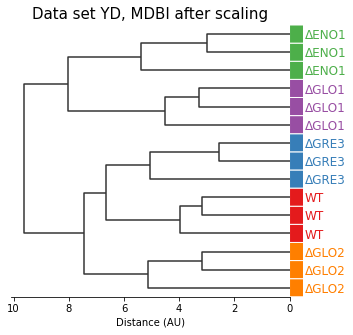

In [47]:
f, ax = plt.subplots(figsize=(5, 5))
name = 'YD'
title = f"Data set {datasets[name]['name']}, MDBI after scaling"
plot_dendogram2(HCA_as['Z'], 
               datasets['YD']['target'], ax=ax,
               label_colors=datasets['YD']['label_colors'], title=title,
               color_threshold=0)

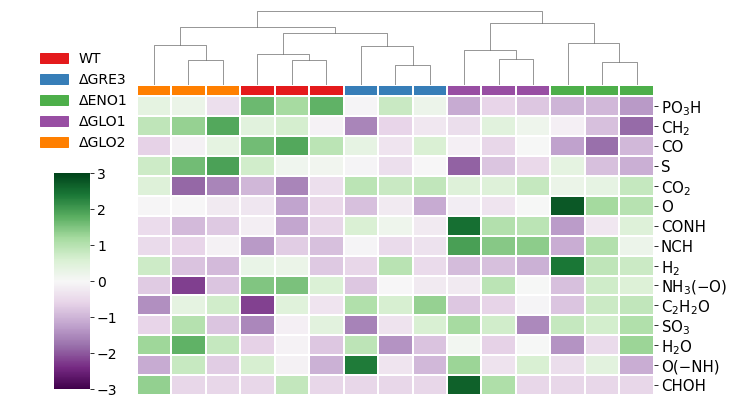

In [48]:
import matplotlib.patches as mpatches
tf = transf.FeatureScaler(method='standard')
df = tf.fit_transform(datasets['YD']['MDBI'].loc[:,list(MDB_RF_Imp_Feat['YD']['Feature'])])

MDB_2 = [f'PO$_3$H', 'CH$_2$', 'CO', 'S', 'CO$_2$', 'O', 'CONH', 'NCH', 'H$_2$', 'NH$_3$(−O)', 'C$_2$H$_2$O', 'SO$_3$',
         'H$_2$O', 'O(−NH)', 'CHOH']

row_cols = [datasets['YD']['label_colors'][lbl] for lbl in datasets['YD']['target']]

g = sns.clustermap(df.T, yticklabels=MDB_2 ,cmap='PRGn', vmin=-3, vmax=3, col_linkage=HCA_as['Z'],  # method='ward',
                    cbar_pos = (0.08, 0.1, 0.05, 0.5), col_colors=row_cols, linewidths=1.5,
                   row_cluster=False)

g.fig.set_size_inches((10,6))

# some tweaks
patches = []
for lbl in datasets['YD']['classes']:
    patches.append(mpatches.Patch(color=datasets['YD']['label_colors'][lbl], label=lbl))
g.ax_heatmap.tick_params(axis='y', labelsize=15)
g.ax_heatmap.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.75, 1.05, 0.5, 1),
                     frameon=False, fontsize=14)
    
# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14) 

g.savefig('images/clustermap_MDBImpact.png' , dpi=600)
g.savefig('images/clustermap_MDBImpact.pdf' , dpi=600)

## Projection in Latent Structures Discriminant Analysis (PLS-DA)

PLS-DA models were built using the `PLSRegression` of scikit-learn.

**Decision Rule**

For the multi-class problem, class membership was encoded by the one-hot encoding method, and the prediction decision samples were assigned to the class corresponding to the maximum value in ypred of the PLS output. For two-class problems, class membership was encoded as 0 or 1, with 0.5 threshold for decision. 

### Optimization - Search for the best number of components of PLS model

The number of components were optimized by the 1 - PRESS/SS or Q$^2$ (PLS Score) of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares; SS - residual Sum of Squares

Strategy: Build PLS-DA with different number of components and extract the PLS score (inverse relation to the mean-squared error ) of the models estimated with stratified k-fold cross-validation. Observe at which point (number of components) the PLS Score starts approaching a "stable maximum value". This was done using the `optim_PLSDA_n_components` from multianalysis.py (see details there).

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [49]:
GENERATE = True #False

In [50]:
%%capture --no-stdout
np.random.seed(16)
if GENERATE:
    # above is to supress PLS warnings

    # Store Results
    PLS_optim = {}

    # Build and extract metrics from models build with different number of components by using the optim_PLS function.
    for name, dataset in datasets.items():
        for treatment in ('NGP', 'NGP_RF', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            print(f'Fitting PLS-DA model for {name} with treatment {treatment}', end=' ...')
            plsdaname = name + ' ' + treatment
            PLS_optim[plsdaname] = {'dskey': name, 'dataset':dataset['name'], 'treatment':treatment}
            n_fold = 5 if name in ('vitis_types', 'HD') else 3
            max_comp = 10 if name.startswith('YD') else 20
            scale = True
            if treatment == 'MDBI':
                max_comp = 10
            elif treatment in ('NGP', 'NGP_RF'):
                scale = False

            optim = ma.optim_PLSDA_n_components(dataset[treatment], dataset['target'],
                                                max_comp=max_comp, n_fold=n_fold, scale=scale).CVscores
            PLS_optim[plsdaname]['CV_scores'] = optim
            print(f'done')
    
    # Store Results
    fname = 'store_files/PLSDA_optim.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLS_optim, write_file)


Fitting PLS-DA model for GD_neg_global2 with treatment NGP ...done
Fitting PLS-DA model for GD_neg_global2 with treatment NGP_RF ...done
Fitting PLS-DA model for GD_neg_global2 with treatment Degree ...done
Fitting PLS-DA model for GD_neg_global2 with treatment Betweenness ...done
Fitting PLS-DA model for GD_neg_global2 with treatment Closeness ...done
Fitting PLS-DA model for GD_neg_global2 with treatment MDBI ...done
Fitting PLS-DA model for GD_neg_global2 with treatment GCD11 ...done
Fitting PLS-DA model for GD_pos_global2 with treatment NGP ...done
Fitting PLS-DA model for GD_pos_global2 with treatment NGP_RF ...done
Fitting PLS-DA model for GD_pos_global2 with treatment Degree ...done
Fitting PLS-DA model for GD_pos_global2 with treatment Betweenness ...done
Fitting PLS-DA model for GD_pos_global2 with treatment Closeness ...done
Fitting PLS-DA model for GD_pos_global2 with treatment MDBI ...done
Fitting PLS-DA model for GD_pos_global2 with treatment GCD11 ...done
Fitting PLS-DA m

In [51]:
# Read prior results
fname = 'store_files/PLSDA_optim.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLS_optim = json.load(read_file)

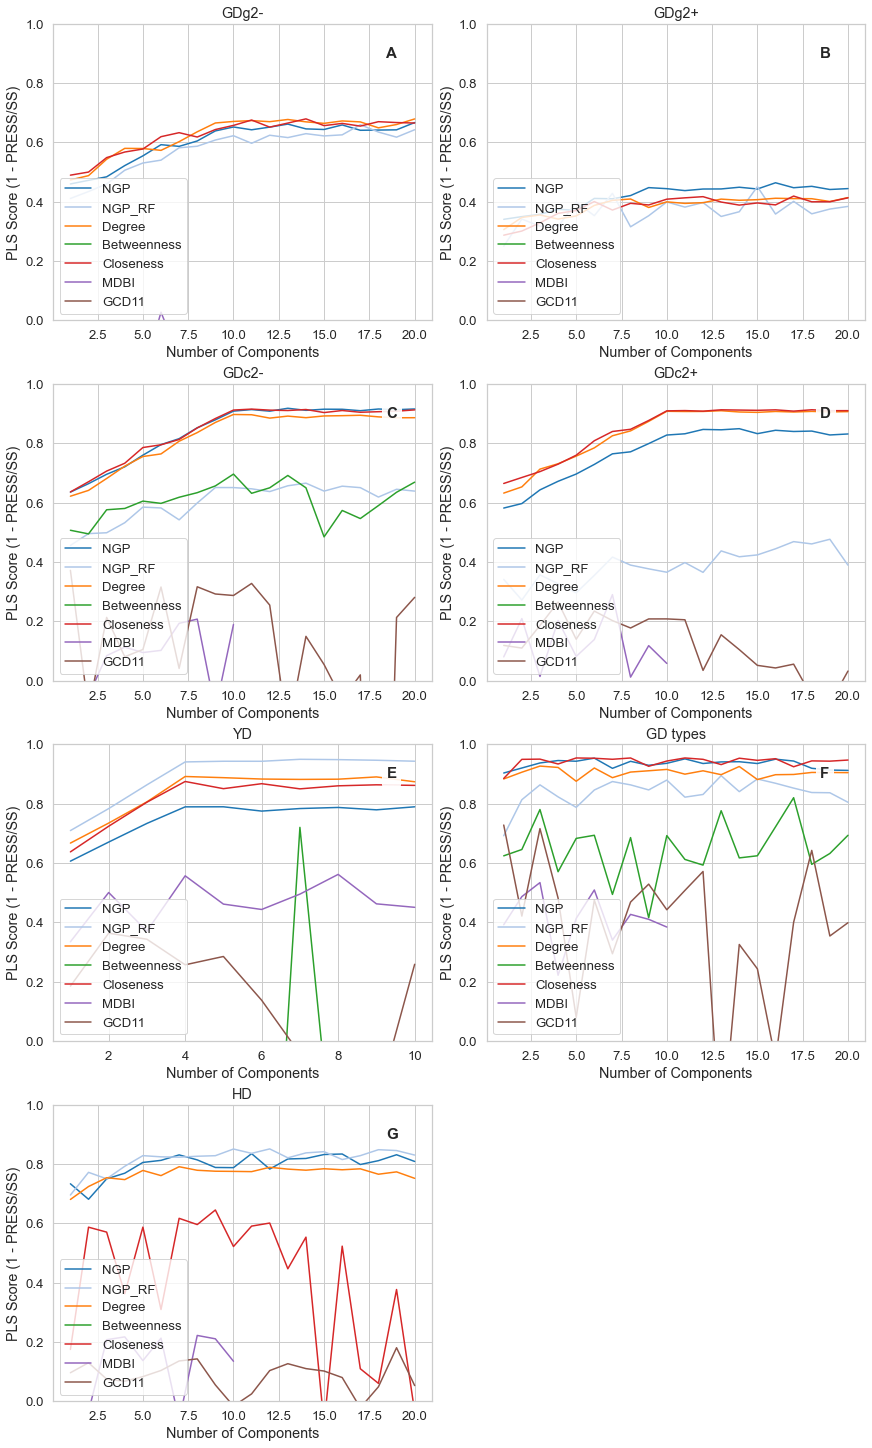

In [52]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(4, 2, figsize=(12,20), constrained_layout=True)
        ranges = [range(i, i+7) for i in (0, 7, 14, 21, 28, 35, 42)]
        titles = ['GDg2-', 'GDg2+', 'GDc2-', 'GDc2+', 'YD', 'GD types', 'HD']
        col = treat_colors[-2:] + treat_colors[1:]
        for irange, title, ax in zip(ranges, titles, axs.ravel()):   
            for i in irange:
                name = list(PLS_optim.keys())[i]
                ax.plot(range(1, len(PLS_optim[name]['CV_scores']) + 1), PLS_optim[name]['CV_scores'], 
                         label=PLS_optim[name]['treatment'], color = col[i%7])
            ax.set(xlabel='Number of Components',
                    ylabel='PLS Score (1 - PRESS/SS)',
                    title=title)
            ax.legend(loc='lower left')
            ax.set_ylim([0, 1])
            
        axs[3][1].remove()

        for letter, ax in zip('ABCDEFGH', axs.ravel()):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.9))

        #f.suptitle('Optimization of the number of trees')
        plt.show()

For the YD and GD types, PLS-DA models are going to be built with 6 components.

For the other GD datasets (GDg2-, GDg2+, GDc2-, GDc2+), PLS-DA models are going to be built with 11 components.

For the HD, PLS-DA models are going to be built with 13 components.

For the MDB Impact analysis of Sample MDiNs, PLS-DA models are going to be built with 5 components.

### PLS-DA models

PLS-DA models were built with the `PLSRegression` (PLS2 algorithm used) from scikit-learn using the `PLSDA_model_CV` from multianalysis.py (each step explained better there).

This function performs n iterations to randomly sample the folds in k-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset. 

It then stores predictive accuracy of the models, the Q$^2$ score (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to a chosen feature importance metric.

The function allows the choice of 3 different feature importance metrics (feat_type):

- **VIP (Variable Importance/Influence in Projection)** - used in the paper (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [53]:
%%capture --no-stdout
np.random.seed(16)
if GENERATE:
    PLSDA_all = {}

    iter_num=20 #20

    # For each differently-treated dataset, fit PLS-DA models on n randomly sampled folds (for stratified cross-validation)
    for name, dataset in datasets.items():
        
        # Intensity-based pre-treatments
        IDT_res = {}
        for treatment in ('NGP', 'NGP_RF'):
            print(f'Fitting a PLS-DA model to {name} with treatment {treatment}', end=' ...')
            IDT_res[treatment] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            if name.startswith('GD'):
                n_comp = 11
            elif name.startswith('HD'):
                n_comp = 13
            else:
                n_comp = 6
                
            n_fold = 5 if name in ('vitis_types', 'HD') else 3
            
            fit = ma.PLSDA_model_CV(dataset[treatment], dataset['target'],
                                    n_comp=n_comp, n_fold=n_fold,
                                    iter_num=iter_num,
                                    scale=False,
                                    feat_type='VIP')
            IDT_res[treatment].update(fit)

            print(f'done')
        
        # Choose the Intensity-based Data pre-Treatment (IDT) with the highest accuracy
        if np.mean(IDT_res['NGP_RF']['accuracy']) >= np.mean(IDT_res['NGP']['accuracy']):
            plsdaname = name + ' ' + 'IDT'
            PLSDA_all[plsdaname] = IDT_res['NGP_RF']
            PLSDA_all[plsdaname]['treatment'] = 'IDT'
        else:
            plsdaname = name + ' ' + 'IDT'
            PLSDA_all[plsdaname] = IDT_res['NGP']
            PLSDA_all[plsdaname]['treatment'] = 'IDT'
        
        # Data matrices from the network analyses of sMDiNs
        for treatment in ('Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):
            print(f'Fitting a PLS-DA model to {name} with treatment {treatment}', end=' ...')
            
            plsdaname = name + ' ' + treatment
            PLSDA_all[plsdaname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            #n_comp = 11 
            if name.startswith('GD'):
                n_comp = 11
            elif name.startswith('HD'):
                n_comp = 13
            else:
                n_comp = 6
            if treatment == 'MDBI':
                n_comp = 5
                
            n_fold = 5 if name in ('vitis_types', 'HD') else 3
            
            fit = ma.PLSDA_model_CV(dataset[treatment], dataset['target'],
                                    n_comp=n_comp, n_fold=n_fold,
                                    iter_num=iter_num,
                                    scale=True,
                                    feat_type='VIP')
            PLSDA_all[plsdaname].update(fit)
            print(f'done')
    
    # Store Results
    PLSDA_all
    fname = 'store_files/PLSDA_all.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLSDA_all, write_file)

Fitting a PLS-DA model to GD_neg_global2 with treatment NGP ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment NGP_RF ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment Degree ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment Betweenness ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment Closeness ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment MDBI ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment GCD11 ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment NGP ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment NGP_RF ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment Degree ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment Betweenness ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment Closeness ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment MDBI ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment GCD11 ...done
Fi

#### Results of the PLS-DA - Performance (Predictive Accuracy) 

In [54]:
# Accuracy across iterations
# Read prior Results
fname = 'store_files/PLSDA_all.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLSDA_all = json.load(read_file)

accuracies = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracies

,GD_neg_global2 IDT,GD_neg_global2 Degree,GD_neg_global2 Betweenness,GD_neg_global2 Closeness,GD_neg_global2 MDBI,GD_neg_global2 GCD11,GD_pos_global2 IDT,GD_pos_global2 Degree,GD_pos_global2 Betweenness,GD_pos_global2 Closeness,...,vitis_types Betweenness,vitis_types Closeness,vitis_types MDBI,vitis_types GCD11,HD IDT,HD Degree,HD Betweenness,HD Closeness,HD MDBI,HD GCD11
0,0.848485,0.909091,0.636364,0.878788,0.454545,0.333333,0.818182,0.666667,0.545455,0.666667,...,0.878788,1.0,0.848485,0.787879,0.991968,0.959839,0.738956,0.895582,0.698795,0.670683
1,0.878788,0.848485,0.606061,0.909091,0.484848,0.424242,0.818182,0.636364,0.454545,0.696970,...,0.878788,1.0,0.848485,0.878788,0.979920,0.967871,0.767068,0.927711,0.702811,0.706827
2,0.939394,0.848485,0.606061,0.878788,0.545455,0.484848,0.848485,0.727273,0.454545,0.666667,...,0.909091,1.0,0.848485,0.818182,0.987952,0.943775,0.783133,0.887550,0.722892,0.698795
3,0.878788,0.878788,0.666667,0.848485,0.545455,0.363636,0.818182,0.696970,0.515152,0.606061,...,0.909091,1.0,0.848485,0.848485,0.979920,0.971888,0.791165,0.915663,0.722892,0.726908
4,0.939394,0.848485,0.666667,0.878788,0.484848,0.424242,0.818182,0.666667,0.575758,0.696970,...,0.787879,1.0,0.818182,0.878788,0.983936,0.971888,0.791165,0.907631,0.722892,0.714859
5,0.878788,0.818182,0.636364,0.909091,0.545455,0.272727,0.848485,0.666667,0.515152,0.696970,...,0.909091,1.0,0.848485,0.878788,0.995984,0.971888,0.787149,0.879518,0.722892,0.674699
6,0.878788,0.848485,0.666667,0.909091,0.484848,0.363636,0.818182,0.727273,0.424242,0.757576,...,0.878788,1.0,0.878788,0.818182,0.975904,0.959839,0.734940,0.895582,0.686747,0.690763
7,0.878788,0.848485,0.666667,0.848485,0.424242,0.393939,0.848485,0.606061,0.454545,0.696970,...,0.878788,1.0,0.818182,0.878788,0.983936,0.975904,0.742972,0.899598,0.726908,0.710843
8,0.878788,0.878788,0.696970,0.848485,0.606061,0.272727,0.818182,0.666667,0.515152,0.666667,...,0.878788,1.0,0.848485,0.818182,0.995984,0.971888,0.783133,0.911647,0.710843,0.686747
9,0.909091,0.848485,0.666667,0.878788,0.515152,0.424242,0.818182,0.696970,0.484848,0.696970,...,0.818182,1.0,0.848485,0.818182,0.987952,0.979920,0.787149,0.891566,0.738956,0.694779


#### Distribution for _GDg2-_

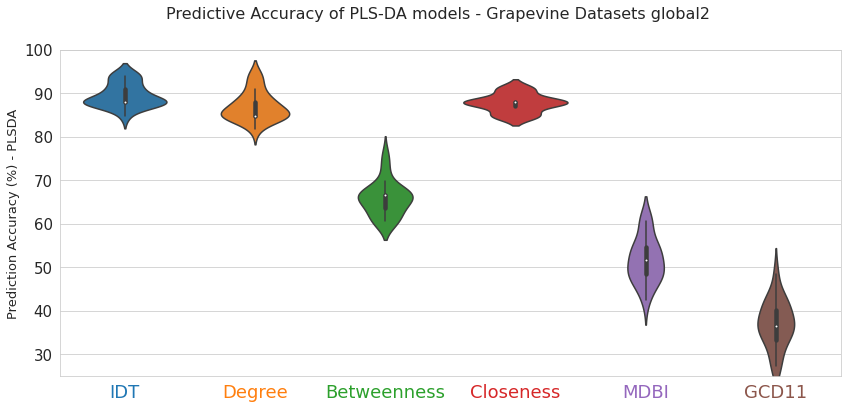

In [55]:
column_names = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11']

# Violin plot of the distribution of the predictive accuracy (in %) across the iterations of randomly sampled folds for each 
# differently-treated dataset.

cols2keep = [col for col in accuracies.columns if 'neg_global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = treat_colors

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - PLSDA', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of PLS-DA models - Grapevine Datasets global2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)

In [56]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 IDT,0.895455,2.688004e-02,GDg2-,IDT
GD_neg_global2 Degree,0.869697,3.275561e-02,GDg2-,Degree
GD_neg_global2 Betweenness,0.657576,3.944911e-02,GDg2-,Betweenness
GD_neg_global2 Closeness,0.877273,2.079796e-02,GDg2-,Closeness
GD_neg_global2 MDBI,0.516667,5.153391e-02,GDg2-,MDBI
GD_neg_global2 GCD11,0.369697,5.348969e-02,GDg2-,GCD11
GD_pos_global2 IDT,0.828788,2.032789e-02,GDg2+,IDT
GD_pos_global2 Degree,0.672727,4.124588e-02,GDg2+,Degree
GD_pos_global2 Betweenness,0.477273,5.806058e-02,GDg2+,Betweenness
GD_pos_global2 Closeness,0.674242,3.527751e-02,GDg2+,Closeness


#### Average Predictive Accuracies of PLS-DA models

Error bars were built based on the standard deviation of the predictive accuracies.

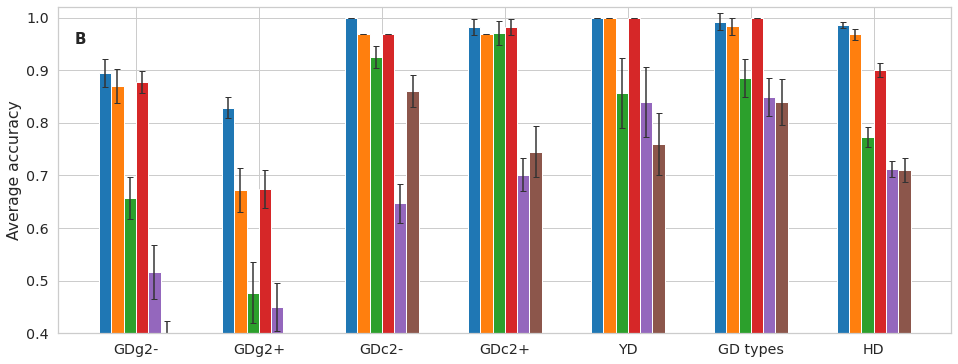

In [57]:
p4 = treat_colors
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.3):
        f, ax = plt.subplots(1, 1, figsize=(16, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.1  # the width of the bars
        for i, treatment in enumerate(('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.25 + i * 0.1
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.4,1.02))
        ax.text(-0.5, 0.95, 'B', weight='bold', fontsize=15)
        #ax.legend(loc='upper left', bbox_to_anchor=(0.12, 1))
        #f.savefig('images/PLSDA_performance.pdf' , dpi=200)
        #f.savefig('images/PLSDA_performance.png' , dpi=600)

### Accuracy plots for RF and PLS-DA together

In [58]:
accuraciesRF = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracy_stats_RF = pd.DataFrame({'Average accuracy': accuraciesRF.mean(axis=0),
                                  'STD': accuraciesRF.std(axis=0)})
accuracy_stats_RF = accuracy_stats_RF.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])


accuraciesPLSDA = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracy_stats_PLSDA = pd.DataFrame({'Average accuracy': accuraciesPLSDA.mean(axis=0),
                                     'STD': accuraciesPLSDA.std(axis=0)})
accuracy_stats_PLSDA = accuracy_stats_PLSDA.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])

In [59]:
def endminus(x):
    if x.endswith('-'):
        return x.replace('-', '−')
    else:
        return x

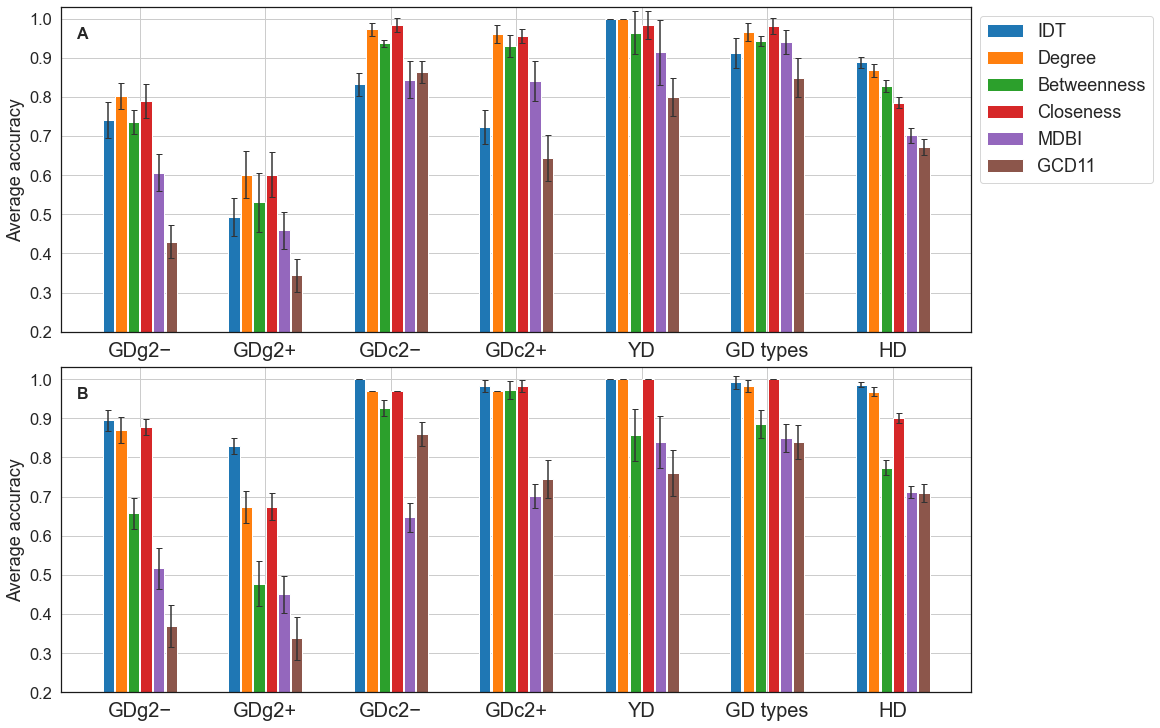

In [60]:
p4 = treat_colors
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, (axu, axl) = plt.subplots(2, 1, figsize=(16, 10), constrained_layout=True)
        x = np.arange(len(datasets))  # the label locations
        labels = [endminus(datasets[name]['name']) for name in datasets]
        width = 0.09  # the width of the bars
        
        for i, treatment in enumerate(('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')):
            acc_treatment = accuracy_stats_RF[accuracy_stats_RF['treatment']==treatment]
            offset = - 0.25 + i * 0.1
            rects = axu.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            axu.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=20)
        axu.set(ylabel='Average accuracy', title='', ylim=(0.2,1.03))
        axu.text(-0.5, 0.95, 'A', weight='bold', fontsize=16)
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        for i, treatment in enumerate(('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11')):
            acc_treatment = accuracy_stats_PLSDA[accuracy_stats_PLSDA['treatment']==treatment]
            offset = - 0.25 + i * 0.1
            rects = axl.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
            axl.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        axl.set_xticks(x)
        axl.set_xticklabels(labels, fontsize=20)
        axl.set(ylabel='Average accuracy', title='', ylim=(0.2,1.03))
        axl.text(-0.5, 0.95, 'B', weight='bold', fontsize=16)
        for spine in axl.spines.values():
            spine.set_edgecolor('0.1')
        axu.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18)
        plt.show()
        f.savefig('images/supervised_performance.pdf' , dpi=600)
        f.savefig('images/supervised_performance.png' , dpi=600)

### Important feature analysis - PLS-DA

**The same process as it was applied for Random Forest.**

In [61]:
MDB_PLSDA_Imp_Feat = {}
for dskey, ds in PLSDA_all.items():
    if dskey.endswith('MDBI'):
        name, treat = dskey.split()
        MDB_PLSDA_Imp_Feat[name] = build_impfeat_table(ds['important_features'], datasets[name][treat], 
                                                     colnames=['Feature', 'VIP Score'])

In [62]:
MDB_PLSDA_Imp_Feat['GD_neg_global2']

,Feature,VIP Score
Place,,
1,CH2,1.219113
2,NCH,1.167844
3,PO3H,1.103994
4,H2,1.083911
5,CHOH,1.078310
6,O,1.061402
7,CO,1.055014
8,CO2,0.982110
9,SO3,0.915355


In [63]:
MDB_PLSDA_Imp_Feat['YD']

,Feature,VIP Score
Place,,
1,NCH,1.197093
2,CO2,1.096458
3,S,1.075138
4,SO3,1.063605
5,C2H2O,1.026394
6,CONH,1.020265
7,PO3H,1.013886
8,CO,1.007725
9,H2,0.998893


In [64]:
MDB_PLSDA_Imp_Feat['vitis_types']

,Feature,VIP Score
Place,,
1,O,1.694845
2,CONH,1.527186
3,H2,1.442450
4,SO3,1.426061
5,NH3(O-),1.122526
6,PO3H,0.943809
7,H2O,0.816562
8,CO,0.755506
9,CHOH,0.743214


In [65]:
MDB_PLSDA_Imp_Feat['HD']

,Feature,VIP Score
Place,,
1,PO3H,1.316471
2,SO3,1.235692
3,NCH,1.184217
4,CO,1.148448
5,O,1.008877
6,CH2,0.992407
7,CONH,0.970636
8,CHOH,0.961054
9,H2O,0.961017


### Example of Sample Projection on the two most important Components/Latent Variables of PLS models built with the full dataset and sample representation 

#### GDg2-, YD, GD types and HD after IDT (NGP or NGP_RF) or after Degree analysis of sMDiNs

In [66]:
# Functions for projection
def plot_PLS(principaldf, label_colors, components=(1,2), title="PLS", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PLS(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')

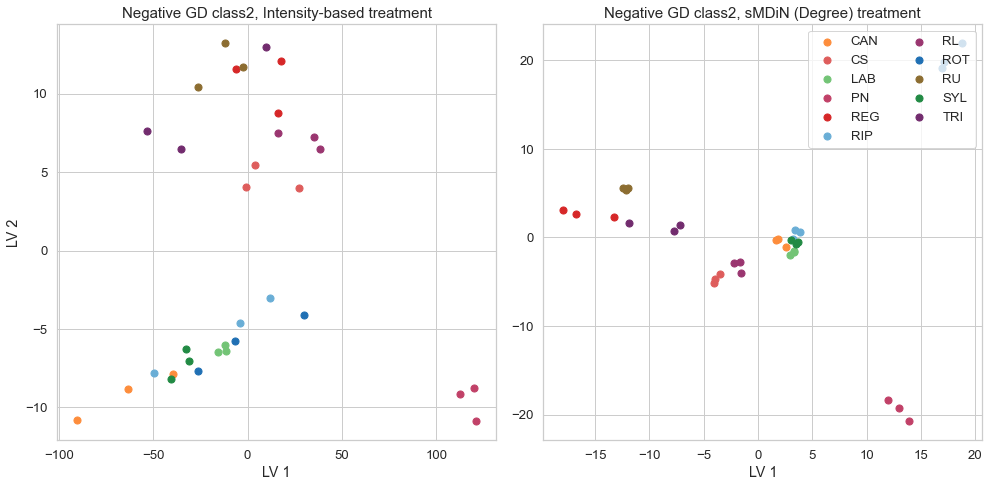

In [67]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['GD_neg_class2']['NGP_RF'],
                                   datasets['GD_neg_class2']['target'], n_comp=n_components, scale=False)
model2, scores2 = ma.fit_PLSDA_model(datasets['GD_neg_class2']['Degree'],
                                     datasets['GD_neg_class2']['target'], n_comp=n_components, scale=True)

lcolors = datasets['GD_neg_class2']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="Negative GD class2, Intensity-based treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="Negative GD class2, sMDiN (Degree) treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

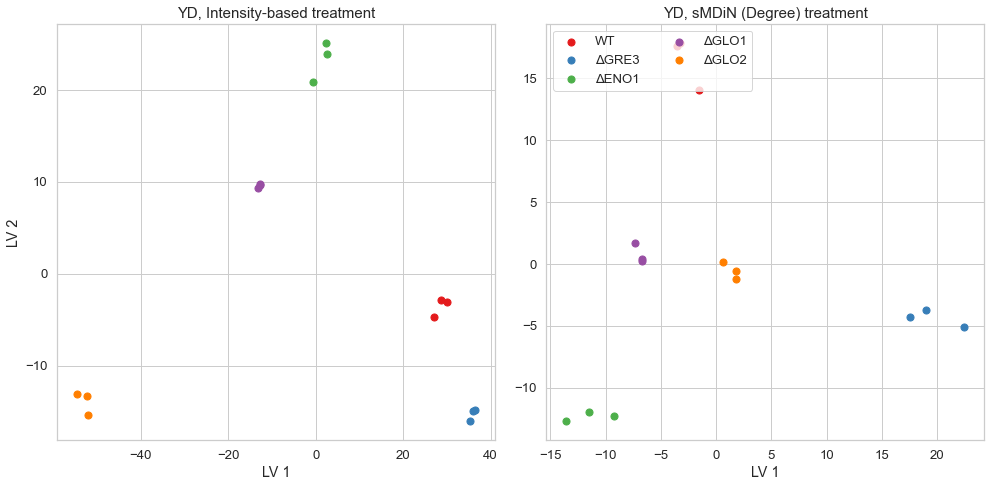

In [68]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['YD']['NGP'],
                                   datasets['YD']['target'], n_comp=n_components, scale=False)
model2, scores2 = ma.fit_PLSDA_model(datasets['YD']['Degree'],
                                     datasets['YD']['target'], n_comp=n_components, scale=True)

lcolors = datasets['YD']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="YD, Intensity-based treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="YD, sMDiN (Degree) treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper left', ncol=2)               
        plt.tight_layout()
        plt.show()

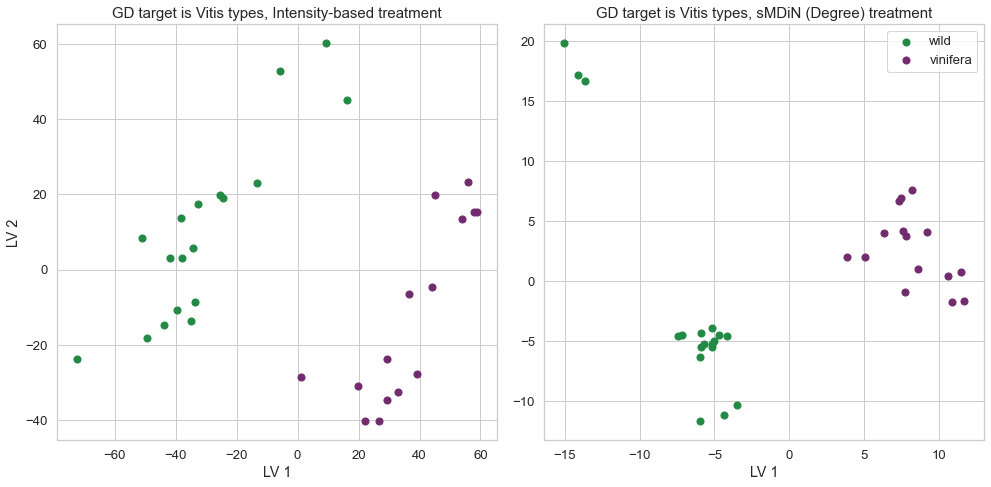

In [69]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['vitis_types']['NGP'],
                                   datasets['vitis_types']['target'], n_comp=n_components, scale=False)
model2, scores2 = ma.fit_PLSDA_model(datasets['vitis_types']['Degree'],
                                     datasets['vitis_types']['target'], n_comp=n_components, scale=True)

lcolors = datasets['vitis_types']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="GD target is Vitis types, Intensity-based treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="GD target is Vitis types, sMDiN (Degree) treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=1)               
        plt.tight_layout()
        plt.show()

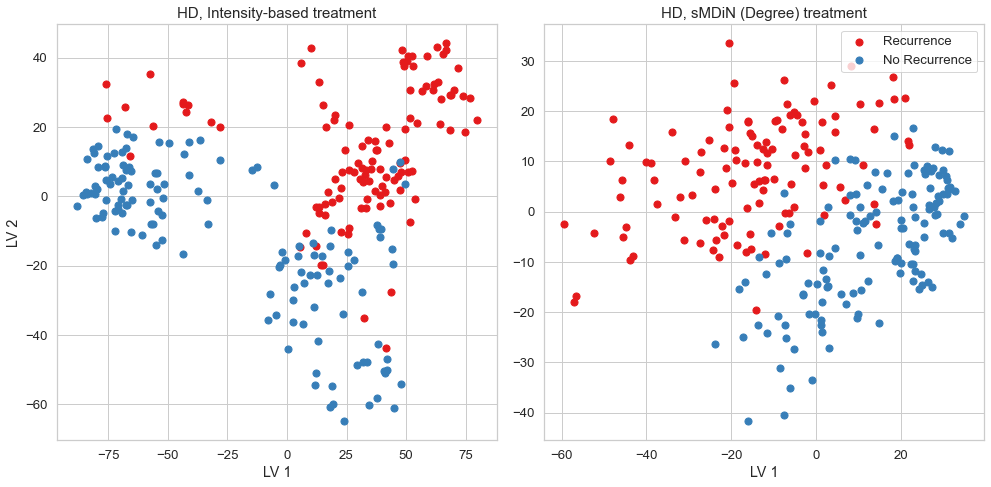

In [70]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['HD']['NGP_RF'],
                                   datasets['HD']['target'], n_comp=n_components, scale=False)
model2, scores2 = ma.fit_PLSDA_model(datasets['HD']['Degree'],
                                     datasets['HD']['target'], n_comp=n_components, scale=True)

lcolors = datasets['HD']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PLS(scores, lcolors, title="HD, Intensity-based treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PLS(scores2, lcolors, title="HD, sMDiN (Degree) treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=1)               
        plt.tight_layout()
        plt.show()